# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

In [12]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
%matplotlib widget

import fastf1
import fastf1.plotting
fastf1.Cache.enable_cache(os.environ['f1_cache'])  

from tensorflow import keras
import keras_tuner

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append(os.environ['f1_install'])
from tools.fastf1_tools import loadTelemForYear, loadTelemForEvent

plt.ion()



In [13]:
# Get speed traces for Max in Abu Dhabi 2022 GP
schedule = fastf1.get_event_schedule(year=2022, include_testing=False)
event = schedule.get_event_by_round(1)
session = event.get_session('R')
session.load()
driver_info = fastf1.api.driver_info(session.api_path)
all_drivers = [d['Tla'] for i, d in driver_info.items()]

path = os.path.join(os.environ['f1_install'], 'dataframes')
telem_param = 'Speed'
refined_laps = loadTelemForEvent(event, path=path, telem_param=telem_param) # Formatted laps generated by ml/save_lap_telemetry.py

print(all_drivers)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
api            INFO 	Using cached data for driver_info


Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Bahrain_Grand_Prix_2022.pkl
['LEC', 'VER', 'SAI', 'PER', 'HAM', 'BOT', 'MAG', 'ALO', 'RUS', 'GAS', 'OCO', 'MSC', 'NOR', 'ALB', 'ZHO', 'TSU', 'HUL', 'RIC', 'STR', 'LAT']


LEC_48


TypeError: pick_track_status() missing 1 required positional argument: 'status'

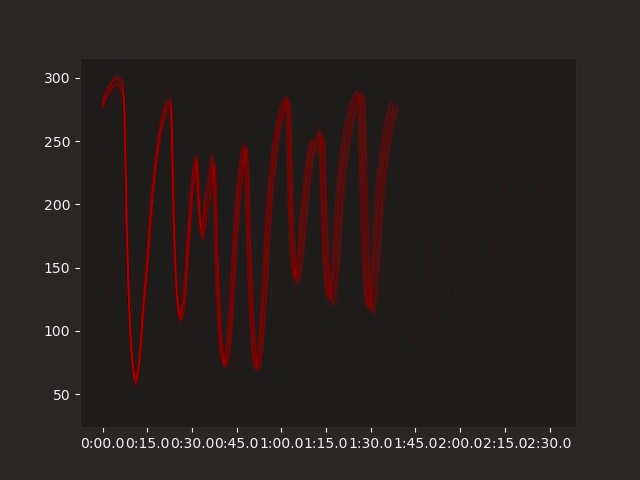

In [67]:
# Quickly plot laps
plt.figure()

for driver in all_drivers:
    driver_laps = refined_laps.loc[:, refined_laps.columns.str.match('{}*'.format(driver))]
    laptimes = driver_laps.notna()[::-1].idxmax()
    min_lap = laptimes.argmin()
    max_lap = laptimes.argmax()
    for i, (lap_name, lap) in enumerate(driver_laps.iteritems()):
        plt.plot(lap, alpha=1.0 if i == min_lap else 2.0/len(driver_laps.columns), c=fastf1.plotting.driver_color(driver), label=driver if i == min_lap else None)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylabel('Speed [km/h]')
plt.xlabel('Time')
plt.title('Driver lap times for loaded session')

### Status
At this point we have obtained a set of consistently formatted (sampled equally in time and of equal length) speed traces.